<h1><center>LOG6953C - TP2</center></h1>

In [2]:
# Vérifier la version de python utilisée
!python -V

Python 3.8.0


In [3]:
# Installation des librairies requises
%pip install qiskit[visualization] numpy prettytable

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit import *
import qiskit.quantum_info as qi
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit.circuit import classical_function, Int1
from math import pi
from prettytable import PrettyTable;

C:\Users\clara\AppData\Local\Temp\ipykernel_29844\38316624.py:9: DeprecationWarning: Accessing 'classical_function' from 'qiskit.circuit' is deprecated since Qiskit Terra 0.22 and will be removed in 0.23.  Import from 'qiskit.circuit.classicalfunction' instead. This will require installing 'tweedledum' as an optional dependency from Terra 0.23.
  from qiskit.circuit import classical_function, Int1
C:\Users\clara\AppData\Local\Temp\ipykernel_29844\38316624.py:9: DeprecationWarning: Accessing 'Int1' from 'qiskit.circuit' is deprecated since Qiskit Terra 0.22 and will be removed in 0.23.  Import from 'qiskit.circuit.classicalfunction.types' instead. This will require installing 'tweedledum' as an optional dependency from Terra 0.23.
  from qiskit.circuit import classical_function, Int1


### Question 1

Option 1

In [5]:
# Implémenter votre logique
@classical_function
def oracle_5qubit(x1: Int1, x2: Int1, x3: Int1, x4: Int1, x5: Int1) -> Int1:
    return not x1 and x2 and x3 and not x4 and x5

In [6]:
shots_number = 100000

In [7]:
# Transformer en circuit
circuit = oracle_5qubit.synth()

inputs = QuantumRegister(5, name='target')  # 5 qubits index 0 is the right most qubit
outputs = QuantumRegister(1, name='fx')  # has to be init to |->
oracle_circuit = QuantumCircuit(inputs, outputs, name='uf')

oracle_circuit.x(outputs[0])
oracle_circuit.h(outputs[0])

# Rajouter au circuit
oracle_circuit.compose(circuit, inplace=True)

oracle_circuit.h(outputs[0])
oracle_circuit.x(outputs[0])

oracle_circuit.to_gate()


Instruction(name='uf', num_qubits=6, num_clbits=0, params=[])

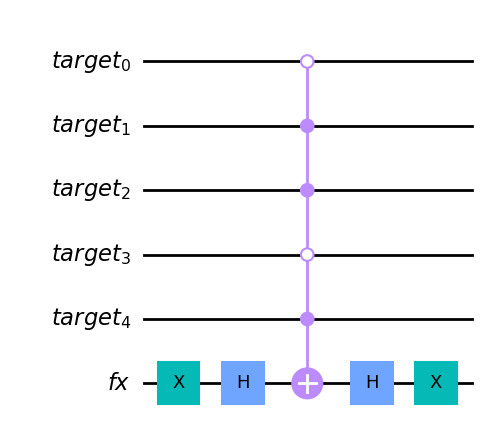

In [8]:
oracle_circuit.draw(output='mpl')

In [9]:
print("Proof of the oracle for '01101'")

table = PrettyTable()
table.field_names = ["target_0", "target_1", "target_2", "target_3", "target_4", "output", "Certainty"]

for x1 in [1, 0]:
    for x2 in [1, 0]:
        for x3 in [1, 0]:
            for x4 in [1, 0]:
                for x5 in [1, 0]:
                    # Transformer en circuit
                    circuit = oracle_5qubit.synth()

                    inputs = QuantumRegister(5, name='target')  # 5 qubits index 0 is the right most qubit
                    outputs = QuantumRegister(1, name='fx')  # has to be init to |->
                    bit_output = ClassicalRegister(1, name='bit_output')
                    oracle_circuit_test = QuantumCircuit(inputs, outputs, bit_output, name='oracle')

                    # We initialize the gates in order to create the truth table
                    oracle_circuit_test.initialize([x1, int(not x1)], inputs[0])
                    oracle_circuit_test.initialize([x2, int(not x2)], inputs[1])
                    oracle_circuit_test.initialize([x3, int(not x3)], inputs[2])
                    oracle_circuit_test.initialize([x4, int(not x4)], inputs[3])
                    oracle_circuit_test.initialize([x5, int(not x5)], inputs[4])
                    # Rajouter au circuit
                    oracle_circuit_test.compose(circuit, inplace=True)

                    oracle_circuit_test.measure(outputs[0], bit_output[0])

                    backend = BasicAer.get_backend('qasm_simulator')

                    # Compiler
                    transpile(oracle_circuit_test, backend)

                    # Run
                    job = execute(oracle_circuit_test, backend, shots=1000)

                    count = job.result().get_counts()
                    out = list(count.keys())[0]
                    table.add_row([f"|{int(not x1)}>", f"|{int(not x2)}>", f"|{int(not x3)}>", f"|{int(not x4)}>", f"|{int(not x5)}>", out[0], count[out]])
                    
print(table)

Proof of the oracle for '01101'
+----------+----------+----------+----------+----------+--------+-----------+
| target_0 | target_1 | target_2 | target_3 | target_4 | output | Certainty |
+----------+----------+----------+----------+----------+--------+-----------+
|   |0>    |   |0>    |   |0>    |   |0>    |   |0>    |   0    |    1000   |
|   |0>    |   |0>    |   |0>    |   |0>    |   |1>    |   0    |    1000   |
|   |0>    |   |0>    |   |0>    |   |1>    |   |0>    |   0    |    1000   |
|   |0>    |   |0>    |   |0>    |   |1>    |   |1>    |   0    |    1000   |
|   |0>    |   |0>    |   |1>    |   |0>    |   |0>    |   0    |    1000   |
|   |0>    |   |0>    |   |1>    |   |0>    |   |1>    |   0    |    1000   |
|   |0>    |   |0>    |   |1>    |   |1>    |   |0>    |   0    |    1000   |
|   |0>    |   |0>    |   |1>    |   |1>    |   |1>    |   0    |    1000   |
|   |0>    |   |1>    |   |0>    |   |0>    |   |0>    |   0    |    1000   |
|   |0>    |   |1>    |   |0>   

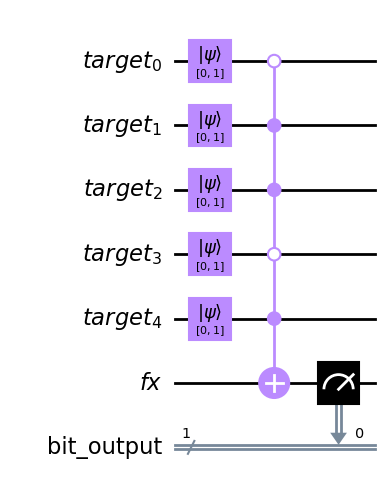

In [10]:
oracle_circuit_test.draw(output='mpl')

Option 2 (unused)

In [11]:
#OPTION 2
def oracle_opt2(target):
    # Create quantum program that find 01101 by reversing its phase
    x = QuantumRegister(len(target), name='target')  # 5 qubits index 0 is the right most qubit
    ancilla = QuantumRegister(1, name='fx')  # has to be init to |->
    oracle_circuit = QuantumCircuit(x, ancilla, name='uf')

    oracle_circuit.x(ancilla)
    # set x qubits so that the target will control the gate
    for i in range(len(target)):
        correct_index = len(target) - i - 1
        if target[correct_index] == '0':
            oracle_circuit.x(x[i])

    oracle_circuit.mcp(pi,x[:], ancilla)  # automatically we get a kickback cause ancilla was in |->

    # reset x qubits to their original state
    for i in range(len(target)):
        correct_index = len(target) - i - 1
        if target[correct_index] == '0':
            oracle_circuit.x(x[i])
    oracle_circuit.x(ancilla)
    oracle_circuit.to_gate()

    return oracle_circuit


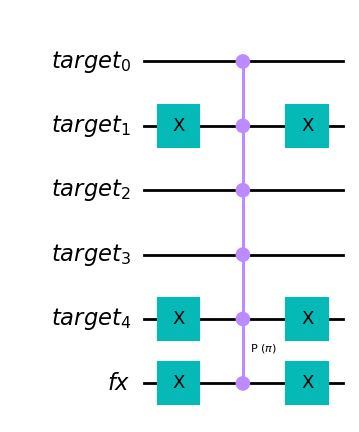

In [12]:
oracle_opt2("01101").draw(output='mpl')

# Question 2

In [13]:
def Z0(target):
    # Create quantum program that find 01101 by reversing its phase
    x = QuantumRegister(len(target), name='target')  # 5 qubits index 0 is the right most qubit
    # ancilla = QuantumRegister(1, name='fx')  # has to be init to |->
    z0 = QuantumCircuit(x, name='z0')

    z0.z(x[0])
    z0.x(x[0])

    z0.z(x[0])
    z0.x(x[0])
    
    # set x qubits so that the target will control the gate
    z0.x(x)

    z0.mcp(pi, x[:-1], x[-1])  # automatically we get a kickback if |0> cause ancilla was in |->
    
    # reset x qubits to their original state
    z0.x(x)

    z0.to_gate()

    return z0

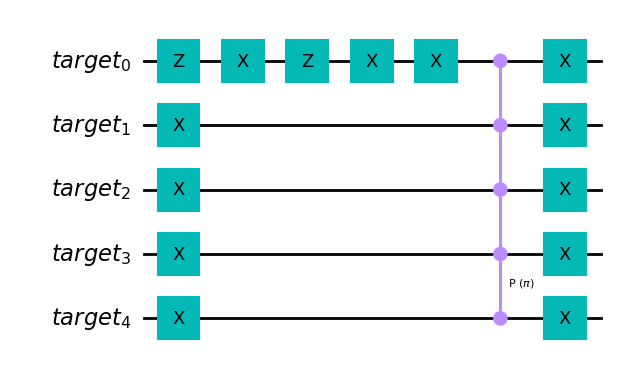

In [25]:
Z0('01101').draw('mpl')

In [26]:
target = '01101'
# curr_oracle = oracle_opt2(target)
curr_oracle = oracle_circuit

z0 = Z0(target)

backend = BasicAer.get_backend('qasm_simulator')

In [27]:
# Create quantum program that find 01101 by reversing its phase
x = QuantumRegister(len(target), name='target')  # 5 qubits index 0 is the right most qubit
ancilla = QuantumRegister(1, name='fx')
res = ClassicalRegister(len(target), name='out')
# ancilla_inversion = QuantumRegister(1, name='fx2')

grover = QuantumCircuit(x, res, ancilla, name='grover')
grover.h(x)
iterations = int((2 ** len(target)) ** (1 / 2))-1
grover.barrier()
for j in range(iterations):

    grover.append(curr_oracle, x[:] + ancilla[:])
    grover.barrier()

    grover.h(x)
    grover.append(z0, x[:])
    grover.h(x)
    grover.barrier()

In [28]:
# Map the quantum measurement to the classical bits
grover.measure(x, res)

# Compiler
compiled_circuit = transpile(grover, backend)

# Run
job = execute(grover, backend, shots=shots_number)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(compiled_circuit)

In [29]:
print(counts)

{'10110': 99924, '10111': 3, '10010': 4, '01100': 5, '11110': 1, '10100': 2, '11100': 3, '11001': 2, '00001': 5, '00000': 2, '01000': 4, '10000': 5, '01011': 1, '11111': 1, '01111': 2, '00100': 2, '10011': 2, '00011': 3, '01101': 3, '01110': 1, '10101': 3, '11000': 1, '01001': 2, '11011': 3, '10001': 3, '00110': 3, '00010': 3, '11101': 1, '11010': 1, '00101': 3, '01010': 2}


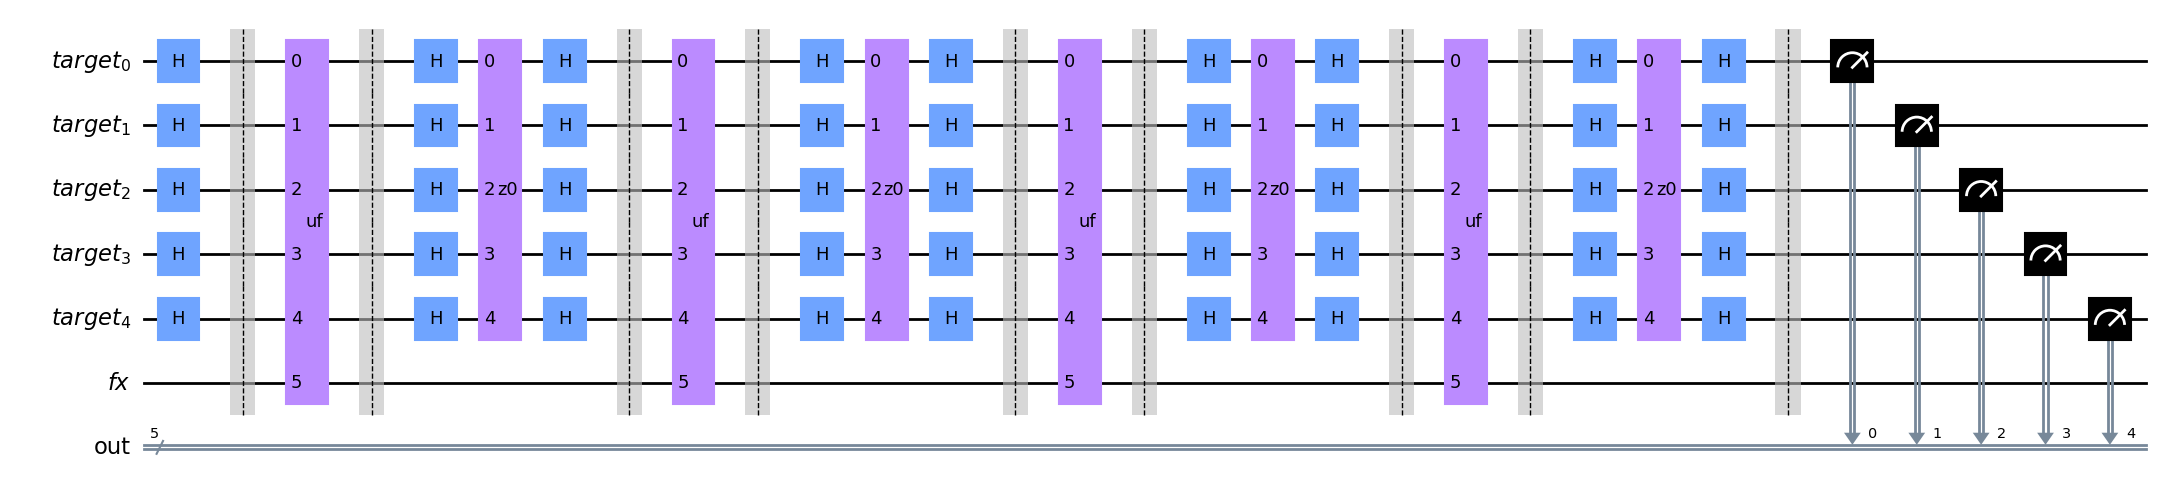

In [30]:
# Draw the circuit
grover.draw('mpl', filename='grover.png', fold=1)

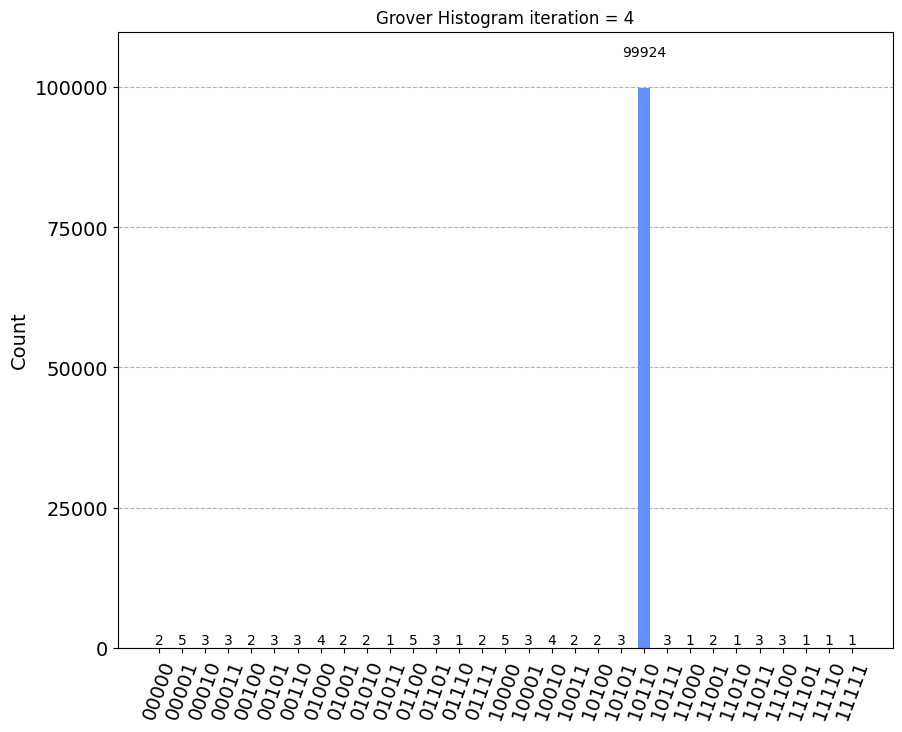

In [31]:
#plot_histogram(counts, filename='grover_hist.png', title='Grover Histogram', bar_labels=True, figsize=(10, 8))
plot_histogram(counts, title=f'Grover Histogram iteration = {iterations}', bar_labels=True, figsize=(10, 8))

Mesures intermédiaires

In [ ]:
iterations = [i for i in range(1,int((2 ** len(target))** (1 / 2))*2)]
print(iterations)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
iterations = [i for i in range(1,(int((2 ** len(target))** (1 / 2))*2)+1)]
result_target = []

for i in iterations:
    # Create quantum program that find 01101 by reversing its phase
    x = QuantumRegister(len(target), name='target')  # 5 qubits index 0 is the right most qubit
    ancilla = QuantumRegister(1, name='fx')
    res = ClassicalRegister(len(target), name='out')
    # ancilla_inversion = QuantumRegister(1, name='fx2')

    grover_inter = QuantumCircuit(x, res, ancilla, name='grover_inter')
    grover_inter.h(x)
    grover_inter.barrier()
    for j in range(i//2):

        grover_inter.append(curr_oracle, x[:] + ancilla[:])
        grover_inter.barrier()

        grover_inter.h(x)
        grover_inter.append(z0, x[:])
        grover_inter.h(x)
        grover_inter.barrier()

    if (i%2)!=0:
        grover_inter.append(curr_oracle, x[:] + ancilla[:])

    # Map the quantum measurement to the classical bits
    grover_inter.measure(x, res)

    compiled_circuit = transpile(grover_inter, backend)

    # Execute the circuit on the qasm simulator
    job = execute(grover_inter, backend, shots=shots_number)

    # Grab results from the job
    result = job.result()

    # Returns counts
    counts = result.get_counts(compiled_circuit)
    result_target.append(counts[target[::-1]]*100/shots_number)
    # Draw the circuit
    grover_inter.draw('mpl', filename=f'grover_iter_{i}.png', fold=1)
    # #plot_histogram(counts, filename='grover_hist.png', title='Grover Histogram', bar_labels=True, figsize=(10, 8))
    plot_histogram(counts, filename=f'grover_hist_iter_{i}.png', title=f'Grover Histogram iteration = {i}', bar_labels=True, figsize=(10, 8))

[3.143, 26.177, 25.885, 60.283, 60.086, 89.73, 89.674, 99.907, 99.928, 85.852]


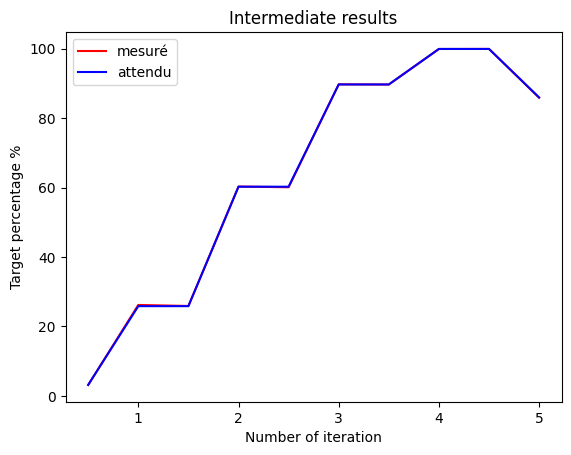

In [ ]:
print(result_target)
result_expected = [3.16,25.83,25.83,60.24,60.24,89.69,89.69,99.92,99.92,85.96]
plt.plot([i/2 for i in iterations], result_target, color='r', label='mesuré')
plt.plot([i/2 for i in iterations], result_expected, color='b', label='attendu')
plt.title("Intermediate results")
plt.xlabel("Number of iteration")
plt.ylabel("Target percentage %")
plt.legend()
plt.show()

# Question 3

In [32]:
IBMQ.save_account(
    'e31a3c8ff39a7a22b6a3052adfb2d4d150b53f5bcac9b161fefba1349302c57ffbf55da2b310ecd734c74be5874804be20d4c1cc4e0345e74db6569e9989fab8',
    overwrite=True)

ibmqfactory.load_account:WARNING:2023-03-14 13:02:49,820: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_jakarta
Job Status: job has successfully run


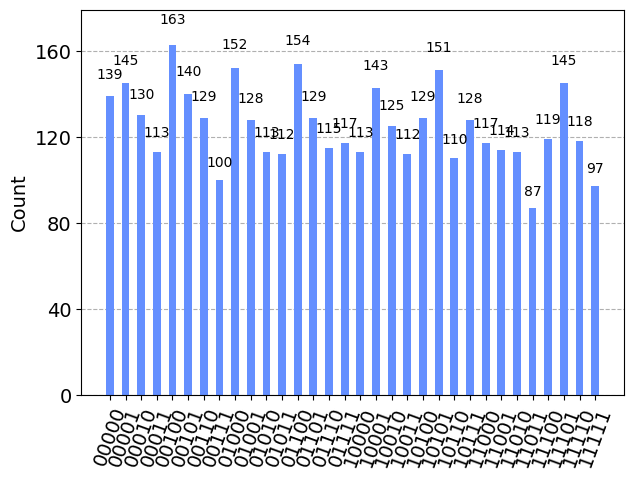

In [33]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 6 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_grover_circuit = transpile(grover, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
qobj = assemble(grover, backend=backend, shots=shots_number)

job_monitor(job, interval=2)
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover)
plot_histogram(answer)